#**system initialization**

mount google drive and change working space to current directory

In [1]:
from google.colab import drive
drive.mount('/content/drive') # mount google drive

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/connected component labeling') # change working directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


import necessary packages 

In [2]:
import cv2
import google.colab.patches as colab
import numpy

from Set import DisjointSet

# **image thresholding**

load the license_plate.bmp image

In [3]:
in_mat = cv2.imread("license_plate.bmp", 0)

threshold input image to binary one by Otsu algorithm

In [4]:
th, binary_mat = cv2.threshold(in_mat, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

display binary image

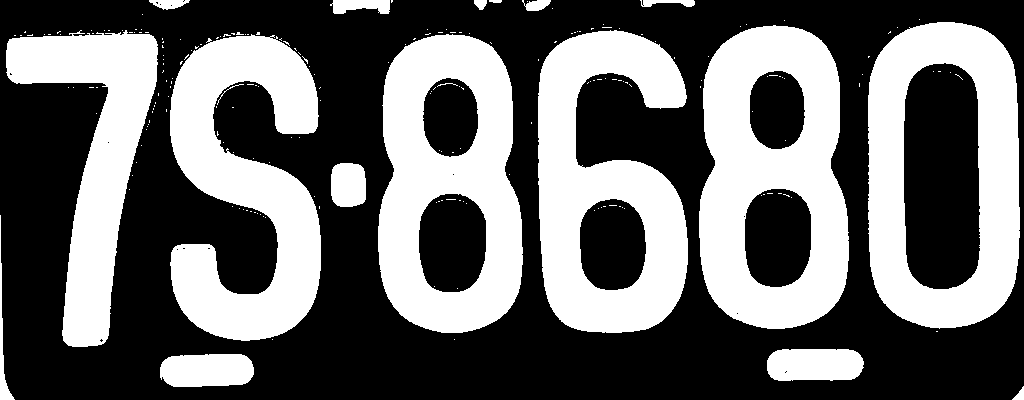

In [5]:
colab.cv2_imshow(binary_mat)

# **connected component labeling**

## **Pass 1**:
(1) assign a temporal label 
(2) record label equivalence

create a label mat and initialize it with the value 0

In [6]:
label_mat = numpy.zeros(binary_mat.shape, dtype=numpy.int32)

set the new_label=1 and equivalences = $\emptyset$

In [7]:
new_label = 1
equivalences = list()

perform the pass 1

In [8]:
for r in range(1, binary_mat.shape[0]):
  for c in range(1, binary_mat.shape[1]):
    if binary_mat[r, c] != 0:

      # (1) assign a temporal label to point (r, c)

      # collect labels in adjacent points including upper and left points
      adjacent_labels = list()
      
      # upper point (r-1, c)
      upper_label = label_mat[r-1, c]
      if (upper_label != 0):
        adjacent_labels.append(upper_label)

      # left point (r, c-1)
      left_label = label_mat[r, c-1]
      if (left_label != 0 and left_label != upper_label):
        adjacent_labels.append(left_label)
      
      # assign label to the point at (r,c) according to adjacent_labels
      if len(adjacent_labels) == 0:
        label_mat[r, c] = new_label   # assign a new label
        new_label = new_label + 1      
      else:
        label_mat[r, c] = min(adjacent_labels) # assign a new label

      #(2) record label equivalence
      if len(adjacent_labels) == 2:
        a_equivalence = list([adjacent_labels[0], adjacent_labels[1]])
        equivalences.append(a_equivalence)

## **Pass2:** 
(1) resolve label equivalence (2) replace temporal labels

create single-integer-item sets from {1}, {2}, .....{new_label}

In [9]:
# resolve label equivalence 
disjoint_set = DisjointSet()
disjoint_set.makeSet(new_label)

for each equivvalence pair $(l_i, l_j)$, unify two sets that contains $l_i$ and $l_j$

In [10]:
for i in range(len(equivalences)):
  a_equivalence = equivalences[i]
  disjoint_set.union(a_equivalence[0], a_equivalence[1])

replace the label at 𝑝 by the minimum of the set containing the label of 𝑝

In [11]:
for r in range(1, label_mat.shape[0]):
  for c in range(1, label_mat.shape[1]):
    if label_mat[r, c] != 0:
      # get the temporal label
      temporal_label = label_mat[r, c]

      # find the minimum label
      min_label = disjoint_set.find(temporal_label)

      # replace the label
      label_mat[r, c] = min_label

# **label mat display**

draw all pixels in each region with the same color

re-assign the labels from 0, 1, 2, ...N-1 (N is the number of regions)

In [12]:
 labels = [0] # let the background as the region 0

 for r in range(1, label_mat.shape[0]):
  for c in range(1, label_mat.shape[1]):
    if label_mat[r, c] != 0:

      # check if the label is in labels
      if not (label_mat[r, c] in labels):
        labels.append(label_mat[r, c])  # add the label to the list

      # replace label by its position index in labels
      label_mat[r, c] = labels.index(label_mat[r, c]) 

get the number of regions

In [13]:
n_regions = len(label_mat)

create a display image and color plate for drawing

In [14]:
display_mat = numpy.zeros((label_mat.shape[0], label_mat.shape[1], 3), dtype=numpy.uint8)
color_plate = numpy.random.randint(0, 256, size=(n_regions, 3))
color_plate[0] = 255 # paint the background (region 0) with white color

paint the display image

In [15]:
for r in range(0, label_mat.shape[0]):
  for c in range(0, label_mat.shape[1]):
    color = color_plate[label_mat[r, c]] # get the color
    display_mat[r, c] = color # paint the point [r,c]

show the display image

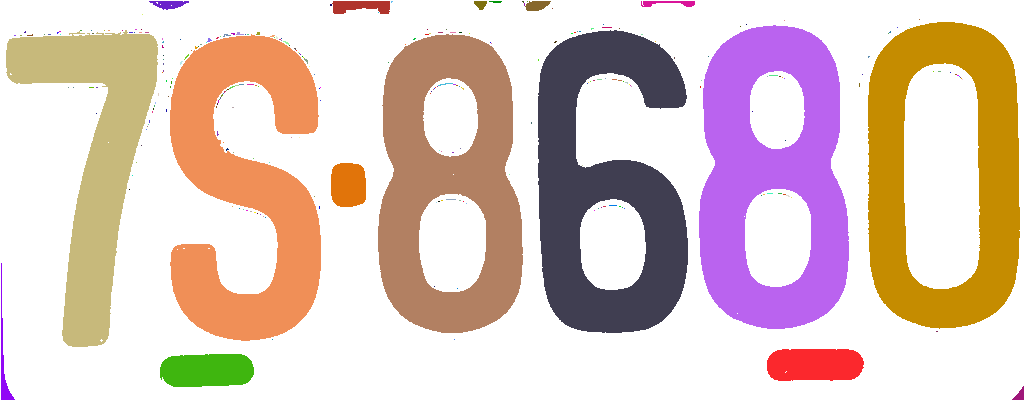

In [16]:
colab.cv2_imshow(display_mat)